In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import os
from astropy.constants import c
from astropy import constants as const
import astropy.units as u
from scipy import special


def weight(n):
    return 2 * n**2

def boltzmann(n1, n2, eV, T):
    k = 8.6173303e-5  # Boltzmann constant in eV/K
    g_n = weight(n2) / weight(n1) * np.exp(-eV / (k * T))
    return g_n

def CIV(T):
    sigma_Lya = 5.9e-14 * (T / 1e4) ** (-1/2)
    sigma_CIV = (0.19 / 0.4164) * sigma_Lya * (12) ** (0.5)
    N_CIV_0 = 1 / sigma_CIV
    return sigma_Lya, sigma_CIV, N_CIV_0

sig_ly, sig_c, N_CIV_0 = CIV(1e5)
print("{:.2e}".format(N_CIV_0))

def tau(sig_c, x):
    return sig_c * x

rr = np.arange(13, 18, 1)
ee = [0]
em = [1]
atom = [13,20,32,50,79]
vran_0 = np.arange(200,2100,100)
# vran_1 = np.arange(1000,3000,500)
# vran = np.append(vran_0,vran_1)
vran = np.append(118,vran_0)

rr_reshaped = rr.reshape(-1, 1)
total_N_c = 10**rr_reshaped * atom / 10
total_N_c = total_N_c.flatten()

C_IV_K = 1548.187e-8  # cm
C_IV_H = 1550.772e-8  # cm

C_IV_K_wo = 1548.187 # cm
C_IV_H_wo = 1550.772  # cm

cc = c.to(u.cm / u.s).value
v_th = 11.7673179819719e5  # cm/s

K_gamma = 2.65e+8
H_gamma = 2.64e+8
f_CIV_K = 0.190
f_CIV_H = 0.0952


directory_1 = '~/RT/C_IV/code_tes/data_ran/'

cc_k = c.to(u.km / u.s).value
V_K = 0
V_H = (C_IV_H/C_IV_K -1 ) * cc_k
def function(sigma,lam,lam_k,lam_h):
    tv_k = ((lam-lam_k) / lam_k ) * cc_k
    tv_h = ((lam-lam_h) / lam_h ) * cc_k
    tk = (tv_k)**2 / sigma**2
    th = (tv_h)**2 / sigma**2
    fx = (1 / np.sqrt(2*np.pi*sigma**2))  *(2*np.exp(-tk/2) + np.exp(-th/2) )
    f0 = fx[np.argmax(fx)]
    return fx , f0

# plt.plot(del_V_space_g,yy_g)

3.39e+13


In [2]:
check = 0
for a , index in enumerate(rr):
    for b, expand in enumerate(ee):
        if expand == 10 :
            expand_v = 1
            num_ev = 2 
        elif expand == 0:
            expand_v = 0
            num_ev = 0
        else: 
            num_ev = 1
            expand_v = expand
        for c, vel in enumerate(vran):
            if vel < 1000 :
                 velr_v = vel
                 num_vr = 1
            else:
                velr_v = int(vel/10)
                num_vr = 2
            for d, atom_n in enumerate(atom):
                path_sp_1 = f'{directory_1}N_atom{atom_n}0E+{index}_Vexp{expand_v}00E+0{num_ev}_Vemit100E+00_tauD000E+00_Vran{velr_v}E+0{num_vr}spec_com.dat'         
                try:
                    data_sp_1 = pd.read_csv(path_sp_1, sep='\s+', header=None)
                except FileNotFoundError:
                    print(f"파일을 찾을 수 없습니다: {path_sp_1}")
                    check += 1
                    continue 

                
                sp_dlam_1 = data_sp_1[0].to_numpy()
                globals()[f'Lambda_{atom_n}_{index}_{expand}_{vel}'] =   sp_dlam_1
                sp_1 = data_sp_1[1].to_numpy()

                indices_K_1 = np.where(sp_dlam_1 <= 1550)[0]
                indices_H_1 = np.where(sp_dlam_1 > 1550)[0]

                sp_dlam_K = sp_dlam_1[indices_K_1]
                sp_dlam_H = sp_dlam_1[indices_H_1]

                dlam_k = sp_dlam_K[1]-sp_dlam_K[0]
                dlam_h = sp_dlam_H[1]-sp_dlam_H[0]
                dlam_sp =sp_dlam_1[1] -sp_dlam_1[0]
                # print(dlam_k ,dlam_h,dlam_sp)

                sp_K = sp_1[indices_K_1]
                sp_H = sp_1[indices_H_1]

                if len(sp_K) == 0 or len(sp_H) == 0:
                    print(f"데이터 부족: {path_sp_1}")
                    continue

                del_V_space = (sp_dlam_1 / C_IV_K_wo  - 1) * cc / 1e5  # km/s

                lam_c = (C_IV_H_wo+C_IV_K_wo) / 2
                # print(sep_point)
                indices_K_sp = np.where(sp_dlam_1 <= lam_c )[0]
                indices_H_sp = np.where(sp_dlam_1> lam_c)[0]

                int_Vel_K = del_V_space[indices_K_sp]
                int_Vel_H = del_V_space[indices_H_sp]

                int_flux_K = sp_1[indices_K_sp]
                int_flux_H = sp_1[indices_H_sp]

                delta_lam_K = sp_dlam_1[indices_K_sp]
                delta_lam_H = sp_dlam_1[indices_H_sp]
                globals()[f'delta_lam_K_{atom_n}_{index}_{expand}_{vel}'] = delta_lam_K
                globals()[f'delta_lam_H_{atom_n}_{index}_{expand}_{vel}'] = delta_lam_H  


                globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{vel}'] = int_Vel_K 
                globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}'] = int_flux_K

                globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{vel}'] = int_Vel_H  
                globals()[f'I_H_f_{atom_n}_{index}_{expand}_{vel}'] = int_flux_H           
print(check)  

0


In [3]:
def finding_FWHM(x, y,v_0):

    aa = np.where(x <= v_0)
    vo = aa[0][-1]
    y_1 = y[:vo+1]
    y_2 = y[vo:]
    x_1 = x[:vo+1]
    x_2 = x[vo:]
    y_1_max = y_1.max()
    y_2_max = y_2.max()
    yc_1 = y_1_max / 2
    yc_2 = y_2_max / 2 
    x_f_1 = []
    x_f_2 = []

    for ii in range(len(y_1) - 1):
        bb_1 = (y_1[ii] - yc_1) * (y_1[ii+1] - yc_1)    
        if bb_1 < 0:
            x_f_1.append(x_1[ii])

    for ii in range(len(y_2) - 1):
        bb_2 = (y_2[ii] - yc_2) * (y_2[ii+1] - yc_2)    
        if bb_2 < 0:
            x_f_2.append(x_2[ii])
    if y_1_max == y[vo] and y_2_max == y[vo]:
        blue_w = abs(max(x_f_1) - x_1[np.argmax(y_1)])
        red_w = abs(min(x_f_2) - x_2[np.argmax(y_2)])      
    
    elif x_f_1 and x_f_2:
        # blue_w = abs(min(x_f_1) - x_1[np.argmax(y_1)])
        blue_w = abs(min(x_f_1) - max(x_f_2))
        red_w = abs(max(x_f_2) - x_2[np.argmax(y_2)])    
    else:
        blue_w = 0
        red_w = 0

    # print(yc_1, yc_2)
    return blue_w, red_w * 2


0.6245745405037441
--------------------------------------------------
K line  FWHM is  32.086311466619165
H line  FWHM is  29.89816831890505
--------------------------------------------------
--------------------------------------------------
K line  FWHM is  77.26275362219357
H line  FWHM is  75.8201282725797
--------------------------------------------------
--------------------------------------------------
K line  FWHM is  129.73946096957013
H line  FWHM is  122.45855987633283
--------------------------------------------------
--------------------------------------------------
K line  FWHM is  250.74571344688198
H line  FWHM is  221.60274497540118
--------------------------------------------------


,Random Velocity [km/s],K line FWHM [km/s],H line FWHM [km/s]
0,11.8,32.1,29.9
1,30.0,77.3,75.8
2,50.0,129.7,122.5
3,100.0,250.7,221.6


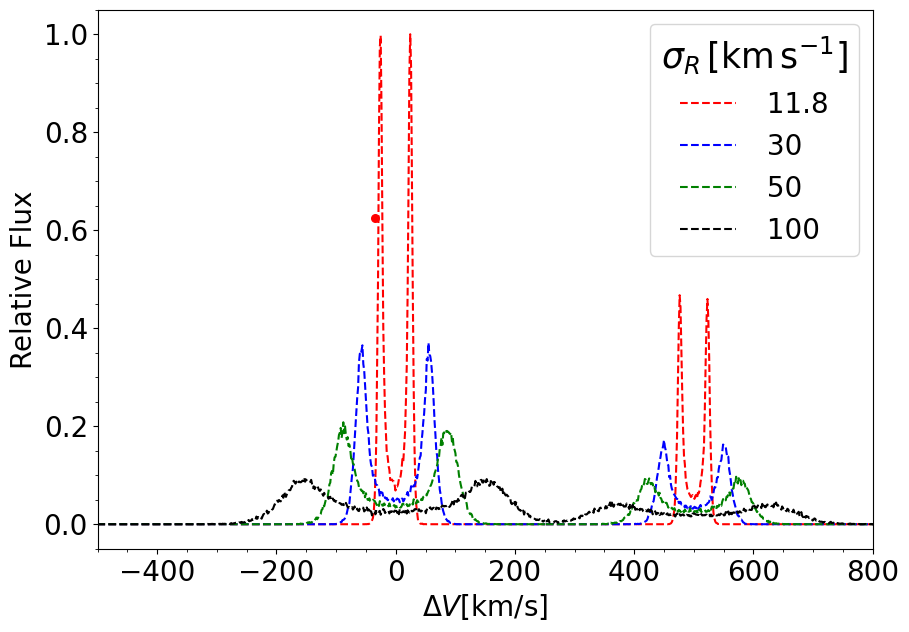

In [4]:
fig = plt.figure(1,figsize=(10,7))

atom_n,index, expand = 32,15,0
vel = 118

normal = max(globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}'])

plt.plot(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}']/normal,'r--',label=f' {vel/10}')
plt.plot(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{vel}'],globals()[f'I_H_f_{atom_n}_{index}_{expand}_{vel}']/normal,'r--')
plt.scatter(-35.45566463209831,2752.5/normal,color='r',s=30)
print(2752.5/normal)
blue_K, red_K = finding_FWHM(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}'],V_K)
blue_H, red_H = finding_FWHM(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_H_f_{atom_n}_{index}_{expand}_{vel}'],V_H)
print('-'*50)
print('K line  FWHM is ', (blue_K +red_K)/2)
print('H line  FWHM is ', (blue_H +red_H)/2)
print('-'*50)
data = {
        'Random Velocity [km/s]': [np.round(vel/10,1)],
        'K line FWHM [km/s]': [np.round((blue_K + red_K) / 2,1)],
        'H line FWHM [km/s]': [np.round((blue_H + red_H) / 2,1)]
    }
df = pd.DataFrame(data)

vel = 300
# normal = max(globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}'])
plt.plot(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}']/normal,'b--',label=f' {int(vel/10)}')
plt.plot(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{vel}'],globals()[f'I_H_f_{atom_n}_{index}_{expand}_{vel}']/normal,'b--')

blue_K, red_K = finding_FWHM(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}'],V_K)
blue_H, red_H = finding_FWHM(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_H_f_{atom_n}_{index}_{expand}_{vel}'],V_H)
print('-'*50)
print('K line  FWHM is ', (blue_K +red_K)/2)
print('H line  FWHM is ', (blue_H +red_H)/2)
print('-'*50)
data = {
        'Random Velocity [km/s]': [np.round(vel/10,1)],
        'K line FWHM [km/s]': [np.round((blue_K + red_K) / 2,1)],
        'H line FWHM [km/s]': [np.round((blue_H + red_H) / 2,1)]
    }
new_df = pd.DataFrame(data)
df = pd.concat([df, new_df], ignore_index=True)
vel = 500
# normal = max(globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}'])
plt.plot(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}']/normal,'g--',label=f' {int(vel/10)}')
plt.plot(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{vel}'],globals()[f'I_H_f_{atom_n}_{index}_{expand}_{vel}']/normal,'g--')
blue_K, red_K = finding_FWHM(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}'],V_K)
blue_H, red_H = finding_FWHM(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_H_f_{atom_n}_{index}_{expand}_{vel}'],V_H)
print('-'*50)
print('K line  FWHM is ', (blue_K +red_K)/2)
print('H line  FWHM is ', (blue_H +red_H)/2)
print('-'*50)

data = {
        'Random Velocity [km/s]': [np.round(vel/10,1)],
        'K line FWHM [km/s]': [np.round((blue_K + red_K) / 2,1)],
        'H line FWHM [km/s]': [np.round((blue_H + red_H) / 2,1)]
    }
new_df = pd.DataFrame(data)
df = pd.concat([df, new_df], ignore_index=True)

vel = 1000
# normal = max(globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}'])
plt.plot(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}']/normal,'k--',label=f' {int(vel/10)}')
plt.plot(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{vel}'],globals()[f'I_H_f_{atom_n}_{index}_{expand}_{vel}']/normal,'k--')
blue_K, red_K = finding_FWHM(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}'],V_K)
blue_H, red_H = finding_FWHM(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_H_f_{atom_n}_{index}_{expand}_{vel}'],V_H)

# plt.scatter(183.22310144681256,275.5/normal,color='k',s=50)
# print(275.5/normal)
print('-'*50)
print('K line  FWHM is ', (blue_K +red_K)/2)
print('H line  FWHM is ', (blue_H +red_H)/2)
print('-'*50)
data = {
        'Random Velocity [km/s]': [np.round(vel/10,1)],
        'K line FWHM [km/s]': [np.round((blue_K + red_K) / 2,1)],
        'H line FWHM [km/s]': [np.round((blue_H + red_H) / 2,1)]
    }
new_df = pd.DataFrame(data)
df = pd.concat([df, new_df], ignore_index=True)

plt.xlabel(r'$\Delta V [\rm km/s]$', fontsize= 20)
plt.ylabel('Relative Flux',fontsize=20)
plt.minorticks_on()
plt.xlim(-500,800)
plt.legend(title=r'$\sigma_R \, [\rm km \, s^{-1}]$', fontsize=20, title_fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.savefig(r'/home/jin/바탕화면/various_random_Velocity.pdf',bbox_inches='tight')
df


--------------------------------------------------
K line  FWHM is  1.452307398921171
H line  FWHM is  2.1978251970548115
--------------------------------------------------
--------------------------------------------------
K line  FWHM is  1.452307398921171
H line  FWHM is  2.1978251970548115
--------------------------------------------------
--------------------------------------------------
K line  FWHM is  148.70659559932852
H line  FWHM is  145.0564630033193
--------------------------------------------------
--------------------------------------------------
K line  FWHM is  151.6015283477803
H line  FWHM is  159.6376292884752
--------------------------------------------------


,Random Velocity [km/s],K line FWHM [km/s],H line FWHM [km/s]
0,50.0,1.5,2.2
1,50.0,1.5,2.2
2,50.0,148.7,145.1
3,50.0,151.6,159.6


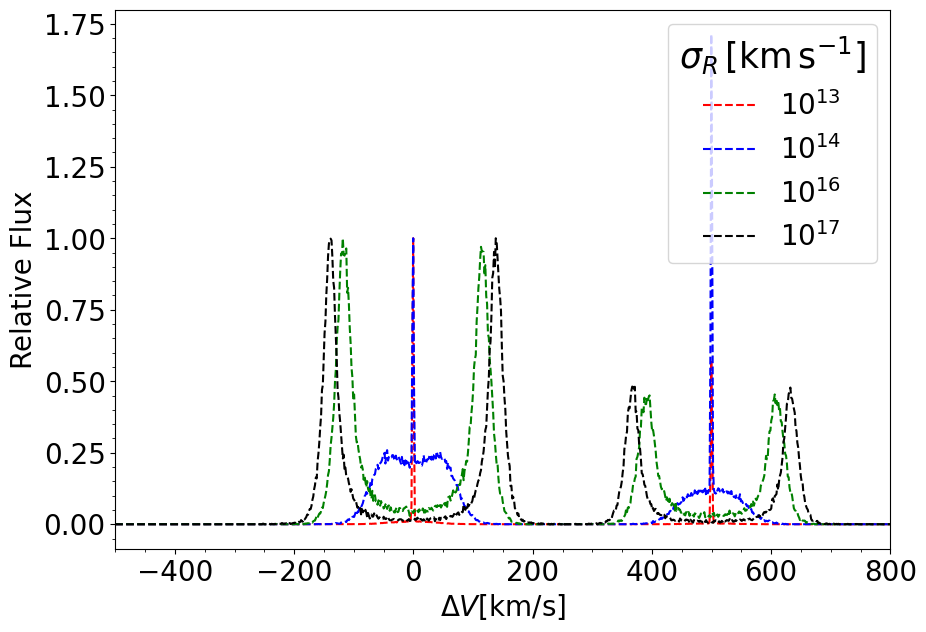

In [5]:
fig = plt.figure(1,figsize=(10,7))

atom_n, expand = 32,0
vel = 500
index = 13
normal = max(globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}'])

plt.plot(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}']/normal,'r--',label=f'$10^{{{index}}}$')
plt.plot(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{vel}'],globals()[f'I_H_f_{atom_n}_{index}_{expand}_{vel}']/normal,'r--')
blue_K, red_K = finding_FWHM(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}'],V_K)
blue_H, red_H = finding_FWHM(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_H_f_{atom_n}_{index}_{expand}_{vel}'],V_H)
print('-'*50)
print('K line  FWHM is ', (blue_K +red_K)/2)
print('H line  FWHM is ', (blue_H +red_H)/2)
print('-'*50)
data = {
        'Random Velocity [km/s]': [np.round(vel/10,1)],
        'K line FWHM [km/s]': [np.round((blue_K + red_K) / 2,1)],
        'H line FWHM [km/s]': [np.round((blue_H + red_H) / 2,1)]
    }
df = pd.DataFrame(data)

index = 14
normal = max(globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}'])
plt.plot(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}']/normal,'b--',label=f'$10^{{{index}}}$')
plt.plot(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{vel}'],globals()[f'I_H_f_{atom_n}_{index}_{expand}_{vel}']/normal,'b--')

blue_K, red_K = finding_FWHM(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}'],V_K)
blue_H, red_H = finding_FWHM(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_H_f_{atom_n}_{index}_{expand}_{vel}'],V_H)
print('-'*50)
print('K line  FWHM is ', (blue_K +red_K)/2)
print('H line  FWHM is ', (blue_H +red_H)/2)
print('-'*50)
data = {
        'Random Velocity [km/s]': [np.round(vel/10,1)],
        'K line FWHM [km/s]': [np.round((blue_K + red_K) / 2,1)],
        'H line FWHM [km/s]': [np.round((blue_H + red_H) / 2,1)]
    }
new_df = pd.DataFrame(data)
df = pd.concat([df, new_df], ignore_index=True)
index = 16
normal = max(globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}'])
plt.plot(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}']/normal,'g--',label=f'$10^{{{index}}}$')
plt.plot(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{vel}'],globals()[f'I_H_f_{atom_n}_{index}_{expand}_{vel}']/normal,'g--')
blue_K, red_K = finding_FWHM(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}'],V_K)
blue_H, red_H = finding_FWHM(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_H_f_{atom_n}_{index}_{expand}_{vel}'],V_H)
print('-'*50)
print('K line  FWHM is ', (blue_K +red_K)/2)
print('H line  FWHM is ', (blue_H +red_H)/2)
print('-'*50)

data = {
        'Random Velocity [km/s]': [np.round(vel/10,1)],
        'K line FWHM [km/s]': [np.round((blue_K + red_K) / 2,1)],
        'H line FWHM [km/s]': [np.round((blue_H + red_H) / 2,1)]
    }
new_df = pd.DataFrame(data)
df = pd.concat([df, new_df], ignore_index=True)

index = 17
normal = max(globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}'])
plt.plot(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}']/normal,'k--',label=f'$10^{{{index}}}$')
plt.plot(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{vel}'],globals()[f'I_H_f_{atom_n}_{index}_{expand}_{vel}']/normal,'k--')
blue_K, red_K = finding_FWHM(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}'],V_K)
blue_H, red_H = finding_FWHM(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_H_f_{atom_n}_{index}_{expand}_{vel}'],V_H)
print('-'*50)
print('K line  FWHM is ', (blue_K +red_K)/2)
print('H line  FWHM is ', (blue_H +red_H)/2)
print('-'*50)
data = {
        'Random Velocity [km/s]': [np.round(vel/10,1)],
        'K line FWHM [km/s]': [np.round((blue_K + red_K) / 2,1)],
        'H line FWHM [km/s]': [np.round((blue_H + red_H) / 2,1)]
    }
new_df = pd.DataFrame(data)
df = pd.concat([df, new_df], ignore_index=True)

plt.xlabel(r'$\Delta V [\rm km/s]$', fontsize= 20)
plt.ylabel('Relative Flux',fontsize=20)
plt.minorticks_on()
plt.xlim(-500,800)
plt.legend(title=r'$\sigma_R \, [\rm km \, s^{-1}]$', fontsize=20, title_fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.savefig(r'/home/jin/바탕화면/various_random_Velocity.pdf',bbox_inches='tight')
df


In [6]:
def finding_FWHM_H(x, y,v_0):

    aa = np.where(x > v_0)
    y_1 = y[aa]
    x_1 = x[aa]
    y_1_max = y_1.max()
    yc_1 = y_1_max / 2
    x_f_1 = []

    for ii in range(len(y_1) - 1):
        bb_1 = (y_1[ii] - yc_1) * (y_1[ii+1] - yc_1)    
        if bb_1 < 0:
            x_f_1.append(x_1[ii])

    
    if x_f_1:
        red_w = abs(max(x_f_1) - x_1[np.argmax(y_1)])

    else:
        red_w = 0

    # print(yc_1, yc_2)
    return red_w * 2


def finding_FWHM_K(x, y,v_0):

    aa = np.where(x < v_0)
    y_1 = y[aa]
    x_1 = x[aa]
    y_1_max = y_1.max()
    yc_1 = y_1_max / 2
    x_f_1 = []

    for ii in range(len(y_1) - 1):
        bb_1 = (y_1[ii] - yc_1) * (y_1[ii+1] - yc_1)    
        if bb_1 < 0:
            x_f_1.append(x_1[ii])

    
    if x_f_1:
        blue_w = abs(min(x_f_1) - x_1[np.argmax(y_1)])

    else:
        blue_w = 0

    # print(yc_1, yc_2)
    return blue_w * 2

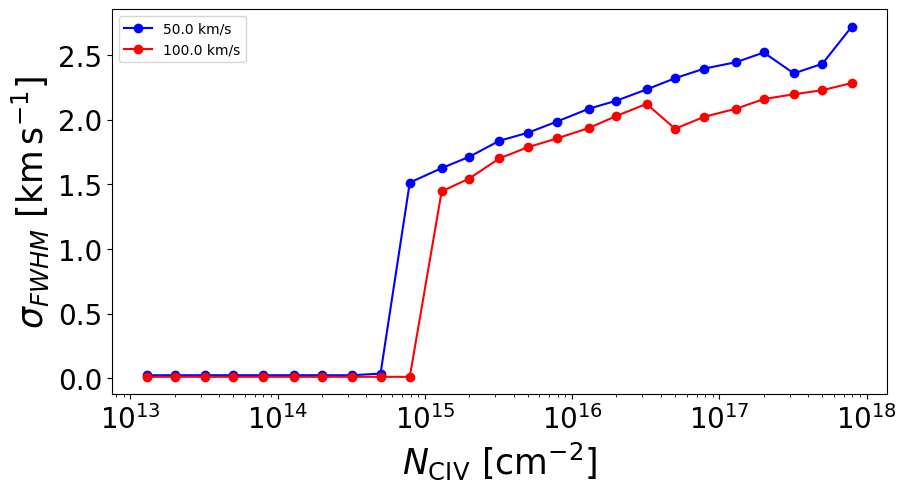

In [7]:
expand = 0
vel = 500
import math
blue_K = np.zeros(len(total_N_c))
red_K = np.copy(blue_K)
blue_H = np.copy(blue_K)
red_H = np.copy(blue_K)

K_FWHM = np.copy(blue_K)
H_FWHM = np.copy(blue_K)
T_FWHM = np.copy(blue_K)
for ii, N_civ in enumerate(total_N_c):
    index = math.floor(math.log10(N_civ))
    atom_n = int(N_civ/ 10**index * 10)
    blue_K[ii], red_K[ii] = finding_FWHM(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}'],V_K)
    blue_H[ii], red_H[ii] = finding_FWHM(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_H_f_{atom_n}_{index}_{expand}_{vel}'],V_H) 
    K_FWHM[ii] = (blue_K[ii] + red_K[ii])/2
    H_FWHM[ii] = (blue_H[ii] + red_H[ii])/2
    T_FWHM[ii] = abs(blue_K[ii]) + abs(red_K[ii])

fig = plt.figure(1,figsize=(10,5))



plt.plot(total_N_c,blue_K/50/2.35,'bo-',label=f'{vel/10} km/s')




vel = 1000
import math
blue_K = np.zeros(len(total_N_c))
red_K = np.copy(blue_K)
blue_H = np.copy(blue_K)
red_H = np.copy(blue_K)

K_FWHM = np.copy(blue_K)
H_FWHM = np.copy(blue_K)
T_FWHM = np.copy(blue_K)
for ii, N_civ in enumerate(total_N_c):
    index = math.floor(math.log10(N_civ))
    atom_n = int(N_civ/ 10**index * 10)
    blue_K[ii], red_K[ii] = finding_FWHM(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}'],V_K)
    blue_H[ii], red_H[ii] = finding_FWHM(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_H_f_{atom_n}_{index}_{expand}_{vel}'],V_H) 
    K_FWHM[ii] = (blue_K[ii] + red_K[ii])/2
    H_FWHM[ii] = (blue_H[ii] + red_H[ii])/2
    T_FWHM[ii] = abs(blue_K[ii]) + abs(red_K[ii])


plt.plot(total_N_c ,blue_K / 100 / 2.35,'ro-',label=f'{vel/10} km/s')


# plt.plot(total_N_c,H_FWHM,'ro-',label='H line')
plt.xscale('log')
plt.xlabel(r'$N_{\rm C IV} ~ [\rm cm^{-2}]$',fontsize=25)
plt.ylabel(r'$\sigma_{FWHM} ~ [\rm km\, s^{-1}]$',fontsize=25)
plt.legend(fontsize=20,ncol=2,title=f'$\sigma_{{R}} = {vel/10} ~~ [\\rm km \\, s^{{-1}}] $',title_fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend()




# plt.savefig(r'/home/jin/바탕화면/column_density_FWHM.pdf',bbox_inches='tight')

(-200.0, 200.0)

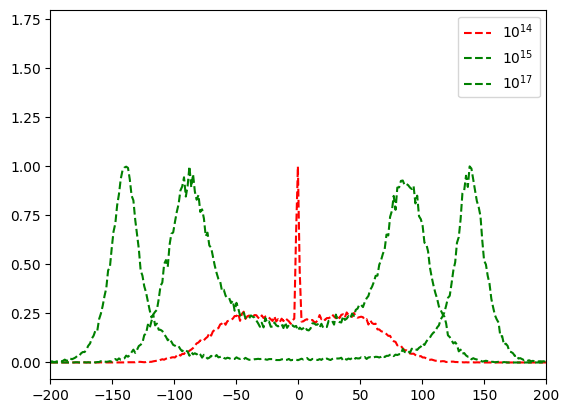

In [8]:
expand = 0
vel = 500
atom_n = 32
index= 14
normal = max(globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}'])
plt.plot(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}']/normal,'r--',label=f'$10^{{{index}}}$')
plt.plot(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{vel}'],globals()[f'I_H_f_{atom_n}_{index}_{expand}_{vel}']/normal,'r--')


index= 15
normal = max(globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}'])
plt.plot(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}']/normal,'g--',label=f'$10^{{{index}}}$')
plt.plot(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{vel}'],globals()[f'I_H_f_{atom_n}_{index}_{expand}_{vel}']/normal,'g--')


index= 17
normal = max(globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}'])
plt.plot(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}']/normal,'g--',label=f'$10^{{{index}}}$')
plt.plot(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{vel}'],globals()[f'I_H_f_{atom_n}_{index}_{expand}_{vel}']/normal,'g--')


plt.legend()
plt.xlim(-200,200)

In [9]:
def finding_FWHM_H(x, y,v_0):

    aa = np.where(x > v_0)
    y_1 = y[aa]
    x_1 = x[aa]
    y_1_max = y_1.max()
    yc_1 = y_1_max / 2
    x_f_1 = []

    for ii in range(len(y_1) - 1):
        bb_1 = (y_1[ii] - yc_1) * (y_1[ii+1] - yc_1)    
        if bb_1 < 0:
            x_f_1.append(x_1[ii])

    
    if x_f_1:
        red_w = abs(max(x_f_1) - x_1[np.argmax(y_1)])

    else:
        red_w = 0

    # print(yc_1, yc_2)
    return red_w * 2


def finding_FWHM_K(x, y,v_0):

    aa = np.where(x < v_0)
    y_1 = y[aa]
    x_1 = x[aa]
    y_1_max = y_1.max()
    yc_1 = y_1_max / 2
    x_f_1 = []

    for ii in range(len(y_1) - 1):
        bb_1 = (y_1[ii] - yc_1) * (y_1[ii+1] - yc_1)    
        if bb_1 < 0:
            x_f_1.append(x_1[ii])

    
    if x_f_1:
        blue_w = abs(min(x_f_1) - x_1[np.argmax(y_1)])

    else:
        blue_w = 0

    # print(yc_1, yc_2)
    return blue_w * 2

(array([  0.,  20.,  40.,  60.,  80., 100., 120.]),
 [Text(0, 0.0, '0'),
  Text(0, 20.0, '20'),
  Text(0, 40.0, '40'),
  Text(0, 60.0, '60'),
  Text(0, 80.0, '80'),
  Text(0, 100.0, '100'),
  Text(0, 120.0, '120')])

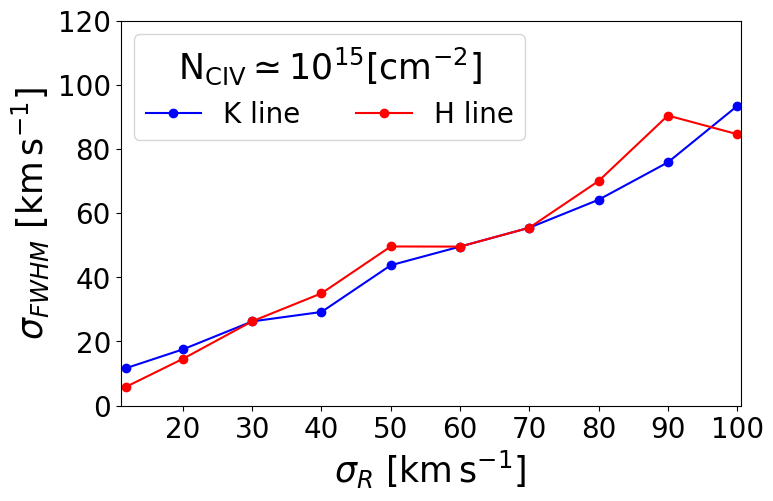

In [10]:
expand = 0
atom_n = 32
index= 15
import math
blue_K = np.zeros(len(vran))
red_K = np.copy(blue_K)
blue_H = np.copy(blue_K)
red_H = np.copy(blue_K)

K_FWHM = np.copy(blue_K)
H_FWHM = np.copy(blue_K)
for ii, vv in enumerate(vran):
    vel = vv
    blue_K[ii] = finding_FWHM_K(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}'],V_K)
    red_H[ii] = finding_FWHM_H(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_H_f_{atom_n}_{index}_{expand}_{vel}'],V_H) 

fig = plt.figure(1,figsize=(8,5))
plt.plot(vran/10,blue_K,'bo-',label='K line')
plt.plot(vran/10,red_H,'ro-',label='H line')
# plt.plot(vran/10,H_FWHM,'ro-',label='H line')
# plt.xscale('log')
plt.xlabel(r'$\sigma_{R} ~ [\rm km \, s^{-1}]$',fontsize=25)
plt.ylabel(r'$\sigma_{FWHM} ~ [\rm km\, s^{-1}]$',fontsize=25)
plt.legend(fontsize=20,ncol=2, title = f'$\\rm N_{{C IV}} \simeq 10^{{{index}}} [\\rm cm^{{-2}}]$',title_fontsize=25)
plt.xlim(11,100+0.5)
plt.ylim(0,120)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# plt.savefig(r'/home/jin/바탕화면/Random_V_FWHM.pdf',bbox_inches='tight')

In [11]:
# expand = 0
# atom_n = 32v_th = 11.7673179819719e5  # cm/s

# K_gamma = 2.65e+8
# vel = 500
# # normal = max(globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}'])
# plt.plot(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}']/normal,'g--',label=f'${{{vel}}}$')
# plt.plot(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{vel}'],globals()[f'I_H_f_{atom_n}_{index}_{expand}_{vel}']/normal,'g--')


# vel = 1000
# # normal = max(globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}'])
# plt.plot(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}']/normal,'k--',label=f'${{{vel}}}$')
# plt.plot(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{vel}'],globals()[f'I_H_f_{atom_n}_{index}_{expand}_{vel}']/normal,'k--')

# plt.xlim(-500,800)
# plt.legend()


3.39e+13
0.29490729441080266


(-5.0, 5.0)

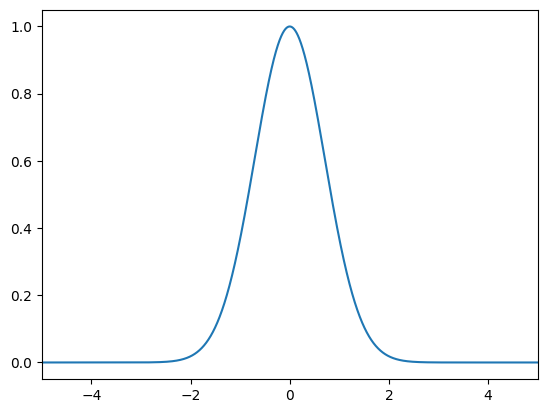

In [34]:
NN = int(1e5)
xx = np.linspace(-5,5,NN)
yy = np.linspace(-5,5,NN)
v_th = 11.7673179819719e5  # cm/s

rr = np.arange(13, 18, 1)
ee = [0]
em = [1]
atom = [13,20,32,50,79]
vran_0 = np.arange(200,2100,100)
# vran_1 = np.arange(1000,3000,500)
# vran = np.append(vran_0,vran_1)
vran = np.append(118,vran_0)

rr_reshaped = rr.reshape(-1, 1)
total_N_c = 10**rr_reshaped * atom / 10
total_N_c = total_N_c.flatten()


K_gamma = 2.65e+8
def VH(x,v_th,gamma_line,lines):
    del_lam_D =  v_th/lines
    a = gamma_line / (4*np.pi*del_lam_D)
    dy = abs(yy[1]- yy[0])
    summ = np.zeros(len(x))
    for aa,bb in enumerate(x):
        for ii,jj in enumerate(yy):
            summ[aa] += np.exp(-jj**2) / ((bb-jj)**2+a**2) *dy
    return summ*a/np.pi


def CIV(T):
    sigma_Lya = 5.9e-14 * (T / 1e4) ** (-1/2)
    sigma_CIV = (0.19 / 0.4164) * sigma_Lya * (12) ** (0.5)
    N_CIV_0 = 1 / sigma_CIV
    return sigma_Lya, sigma_CIV, N_CIV_0

sig_ly, sig_c, N_CIV_0 = CIV(1e5)
print("{:.2e}".format(N_CIV_0))

def tau(sig_c, x):
    return sig_c * x

tt = tau(sig_c,1*1e13)
print(tt)
plt.plot(xx, VH(xx,v_th,K_gamma ,C_IV_K))
plt.xlim(-5,5)